In [5]:
#%% -------- 1. Imports & Configuration --------
import warnings
warnings.filterwarnings('ignore')
import os
import cv2
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from skimage import feature
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, 
                             confusion_matrix, classification_report)
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers


# Configuration
TARGET_SIZE = (650, 325)
DATA_PATHS = {
    'train': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\train",
    'valid': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\val",
    'test': "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test"
}

In [6]:
#%% -------- 2. Metaheuristic Optimizers --------
class PSOFeatureSelector:
    def __init__(self, n_particles=20, iterations=50):
        self.n_particles = n_particles
        self.iterations = iterations
        self.best_features = None

    def optimize(self, X, y):
        n_features = X.shape[1]
        particles = np.random.rand(self.n_particles, n_features)
        velocities = np.zeros_like(particles)
        pbest = particles.copy()
        pbest_scores = np.zeros(self.n_particles)
        gbest, gbest_score = None, 0

        for i in range(self.n_particles):
            score = self._fitness(X, y, particles[i])
            pbest_scores[i] = score
            if score > gbest_score:
                gbest_score, gbest = score, particles[i].copy()

        for _ in range(self.iterations):
            for i in range(self.n_particles):
                r1, r2 = np.random.rand(2)
                velocities[i] += 2*r1*(pbest[i] - particles[i]) + \
                                2*r2*(gbest - particles[i])
                particles[i] = 1/(1+np.exp(-velocities[i]))
                score = self._fitness(X, y, particles[i])
                if score > pbest_scores[i]:
                    pbest_scores[i] = score
                    pbest[i] = particles[i].copy()
                    if score > gbest_score:
                        gbest_score, gbest = score, particles[i].copy()

        self.best_features = gbest > 0.5
        return self.best_features

    def _fitness(self, X, y, particle):
        mask = particle > 0.5
        if sum(mask) == 0: return 0
        return cross_val_score(LogisticRegression(), X[:,mask], y, 
                             cv=3, scoring='accuracy').mean()

class GWOFeatureSelector:
    def __init__(self, n_wolves=20, iterations=50):
        self.n_wolves = n_wolves
        self.iterations = iterations
        self.best_features = None

    def optimize(self, X, y):
        n_features = X.shape[1]
        wolves = np.random.rand(self.n_wolves, n_features)
        alpha = beta = delta = None
        alpha_score = beta_score = delta_score = -np.inf

        for it in range(self.iterations):
            scores = [self._fitness(X, y, wolf) for wolf in wolves]
            for i, score in enumerate(scores):
                if score > alpha_score:
                    alpha_score, beta_score, delta_score = score, alpha_score, beta_score
                    alpha, beta, delta = wolves[i].copy(), alpha, beta
                elif score > beta_score:
                    beta_score, delta_score = score, beta_score
                    beta, delta = wolves[i].copy(), beta
                elif score > delta_score:
                    delta_score = score
                    delta = wolves[i].copy()

            a = 2 - 2*(it/self.iterations)
            for i in range(self.n_wolves):
                A1, A2, A3 = a*(2*np.random.rand(3)-1)
                D_alpha = np.abs(A1*alpha - wolves[i])
                D_beta = np.abs(A2*beta - wolves[i])
                D_delta = np.abs(A3*delta - wolves[i])
                wolves[i] = (alpha - A1*D_alpha + 
                            beta - A2*D_beta + 
                            delta - A3*D_delta)/3

        self.best_features = alpha > 0.5
        return self.best_features

    def _fitness(self, X, y, wolf):
        mask = wolf > 0.5
        if sum(mask) == 0: return 0
        return cross_val_score(LogisticRegression(), X[:,mask], y,
                             cv=3, scoring='accuracy').mean()

In [7]:
#%% -------- 3. CNN Architecture & Feature Extraction --------
class CNNFetaureExtractor:
    def __init__(self, params):
        self.model = self._build_cnn(params)
        self.feature_model = self._build_feature_extractor()

    def _build_cnn(self, params):
        base = Sequential([
            layers.Conv2D(params['filters1'], (3,3), activation='relu', 
                        input_shape=(*TARGET_SIZE, 1)),
            layers.MaxPooling2D(2,2),
            layers.Conv2D(params['filters2'], (3,3), activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(params['dense_units'], activation='relu'),
            layers.Dropout(params['dropout']),
            layers.Dense(1, activation='sigmoid')
        ])
        base.compile(optimizer=optimizers.Adam(learning_rate=params['learning_rate']),
                   loss='binary_crossentropy', metrics=['accuracy'])
        return base

    def _build_feature_extractor(self):
        return Model(inputs=self.model.input, 
                   outputs=self.model.layers[-3].output)

    def extract_features(self, images):
        return self.feature_model.predict(images)

In [8]:
#%% -------- 4. Data Loading & Processing --------
def load_images(directory):
    images, labels = [], []
    for label in ['female', 'male']:
        path = os.path.join(directory, label)
        for file in os.listdir(path):
            img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, TARGET_SIZE).reshape(*TARGET_SIZE, 1)
                images.append(img/255.0)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load datasets
train_images, train_labels = load_images(DATA_PATHS['train'])
valid_images, valid_labels = load_images(DATA_PATHS['valid'])
test_images, test_labels = load_images(DATA_PATHS['test'])

# Encode labels
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
valid_labels = le.transform(valid_labels)
test_labels = le.transform(test_labels)

#%% -------- 5. Hybrid Training Pipeline --------
# Initialize with optimized parameters
best_params = {
    'learning_rate': 0.00096,
    'filters1': 27,
    'filters2': 63,
    'dense_units': 99,
    'dropout': 0.46
}

# 1. Train CNN
cnn_system = CNNFetaureExtractor(best_params)
cnn_system.model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=15)]
)

# 2. Extract CNN features
train_features = cnn_system.extract_features(train_images)
valid_features = cnn_system.extract_features(valid_images)
test_features = cnn_system.extract_features(test_images)

# 3. Prepare feature matrix
X_full = np.vstack([train_features, valid_features])
y_full = np.concatenate([train_labels, valid_labels])
X_full, y_full = SMOTE().fit_resample(X_full, y_full)

# 4. Feature Selection
pso = PSOFeatureSelector(n_particles=30)
pso_mask = pso.optimize(X_full, y_full)
X_pso = X_full[:, pso_mask]

gwo = GWOFeatureSelector(n_wolves=30)
gwo_mask = gwo.optimize(X_pso, y_full)
X_selected = X_pso[:, gwo_mask]

Epoch 1/50
22/22 [==============================] - 77s 3s/step - loss: 0.6899 - accuracy: 0.4927 - val_loss: 0.6840 - val_accuracy: 0.5000
Epoch 2/50
22/22 [==============================] - 74s 3s/step - loss: 0.6773 - accuracy: 0.5379 - val_loss: 0.6669 - val_accuracy: 0.5000
Epoch 3/50
22/22 [==============================] - 72s 3s/step - loss: 0.6532 - accuracy: 0.6239 - val_loss: 0.6241 - val_accuracy: 0.7296
Epoch 4/50
22/22 [==============================] - 73s 3s/step - loss: 0.5812 - accuracy: 0.7638 - val_loss: 0.5335 - val_accuracy: 0.8520
Epoch 5/50
22/22 [==============================] - 74s 3s/step - loss: 0.4902 - accuracy: 0.7784 - val_loss: 0.4710 - val_accuracy: 0.8010
Epoch 6/50
22/22 [==============================] - 76s 3s/step - loss: 0.4212 - accuracy: 0.7930 - val_loss: 0.3803 - val_accuracy: 0.8469
Epoch 7/50
22/22 [==============================] - 75s 3s/step - loss: 0.3699 - accuracy: 0.8192 - val_loss: 0.3621 - val_accuracy: 0.7806
Epoch 8/50
22/22 [==

In [9]:
# 5. Train final classifier
classifier = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', 
                              solver='saga', max_iter=2000))
])
classifier.fit(X_selected, y_full)

# 6. Prepare test features
X_test_pso = test_features[:, pso.best_features]
X_test_selected = X_test_pso[:, gwo.best_features]

Test Accuracy: 91.75%
AUC-ROC: 96.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.91        49
           1       0.88      0.96      0.92        48

    accuracy                           0.92        97
   macro avg       0.92      0.92      0.92        97
weighted avg       0.92      0.92      0.92        97



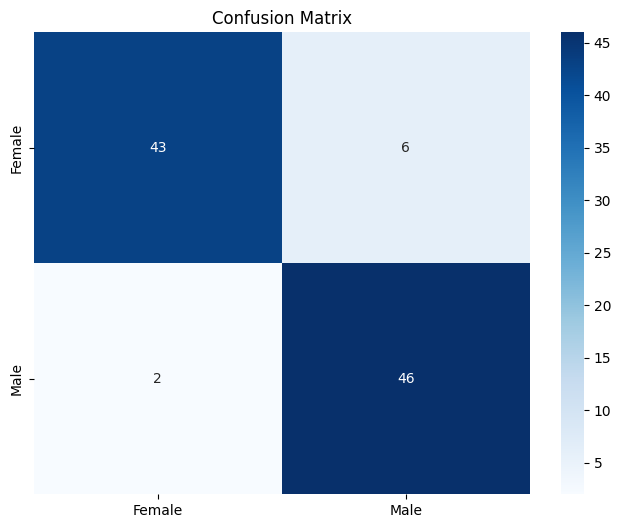

In [11]:
import seaborn as sns

#%% -------- 6. Evaluation --------
test_pred = classifier.predict(X_test_selected)
test_proba = classifier.predict_proba(X_test_selected)[:, 1]

print(f"Test Accuracy: {accuracy_score(test_labels, test_pred):.2%}")
print(f"AUC-ROC: {roc_auc_score(test_labels, test_proba):.2%}")
print("\nClassification Report:")
print(classification_report(test_labels, test_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_labels, test_pred), 
           annot=True, fmt='d', cmap='Blues',
           xticklabels=['Female', 'Male'], 
           yticklabels=['Female', 'Male'])
plt.title("Confusion Matrix")
plt.show()

In [12]:
#%% -------- 7. Model Saving --------
save_data = {
    'cnn_model': cnn_system.model,
    'pso_mask': pso.best_features,
    'gwo_mask': gwo.best_features,
    'classifier': classifier,
    'label_encoder': le
}
joblib.dump(save_data, 'hybrid_gender_classifier.pkl')

['hybrid_gender_classifier.pkl']

In [13]:
#%% -------- 8. Inference Function --------
def predict_gender(image_path):
    # Load components
    model_data = joblib.load('hybrid_gender_classifier.pkl')
    cnn = model_data['cnn_model']
    pso_mask = model_data['pso_mask']
    gwo_mask = model_data['gwo_mask']
    classifier = model_data['classifier']
    le = model_data['label_encoder']
    
    # Process image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, TARGET_SIZE).reshape(1, *TARGET_SIZE, 1)/255.0
    
    # Extract features
    cnn_features = Model(inputs=cnn.input, 
                        outputs=cnn.layers[-3].output).predict(img)
    
    # Select features
    features_pso = cnn_features[:, pso_mask]
    features_selected = features_pso[:, gwo_mask]
    
    # Predict
    proba = classifier.predict_proba(features_selected)[0]
    return 'Male' if proba[1] > 0.5 else 'Female', max(proba)

# Example usage
test_image = "D:\\level4__semester1\\AI-Based\\AI-Driven Gender Classification Using Panoramic Dental X-Rays\\Radiographs\\test\\male\\male.441.JPG"
pred, confidence = predict_gender(test_image)
print(f"Prediction: {pred} with {confidence:.2%} confidence")

1/1 [==============================] - 0s 90ms/step
Prediction: Male with 99.13% confidence
